### Content
- intro to method
- adversarial detection on CIFAR-10
  - [x] illustrate detection + correction: figure 1
  - [x] compute some numbers from the tables + ROC curves
  - [x] show improvement with temperature and HL
  - [ ] comparison with MSE (incl. ROC curve?!)
- concept drift on CIFAR-10-C
  - [ ] incl. figure 7
- [ ] detection system performance

### TODO
#### Datasets, models and fetch fn
- [x] upload C&W + SLIDE attack datasets (train + test) on CIFAR-10 classifiers to bucket
- [x] upload pretrained ResNet-56 and simple CNN classifiers on CIFAR-10 to bucket
- [x] upload pre-trained detectors for KL, T-scaling and hidden K-L for both classifiers
- [x] upload CIFAR-10-C to bucket + fetch fn
- [ ] generic fetch_fn for ad and od for detectors in the bucket
- [x] fetch fn for attacks in the bucket

# Adversarial AE detection and correction on CIFAR-10

Requirements: python 3.7 & GPU

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy
from scipy.stats import ks_2samp
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
from tqdm import tqdm

from alibi_detect.ad import AdversarialAE
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.datasets import fetch_attack, fetch_cifar10c, corruption_types_cifar10c
from tensorflow.python.keras import backend

physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

### Utility functions

In [2]:
def scale_by_instance(X: np.ndarray) -> np.ndarray:
    mean_ = X.mean(axis=(1, 2, 3)).reshape(-1, 1, 1, 1)
    std_ = X.std(axis=(1, 2, 3)).reshape(-1, 1, 1, 1)
    return (X - mean_) / std_, mean_, std_


def accuracy(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return (y_true == y_pred).astype(int).sum() / y_true.shape[0]


def predict_batch(model: tf.keras.Model, 
                  X: np.ndarray, 
                  batch_size: int = 32, 
                  recon: bool = False,
                  proba: bool = False,
                  n_categories: int = 10) -> np.ndarray:
    n = X.shape[0]
    if recon:
        shape = X.shape
        dtype = np.float32
    elif proba:
        shape = (n, n_categories)
        dtype = np.float32
    else:
        shape = (n,)
        dtype = np.int64
    preds = np.zeros(shape, dtype=dtype)
    n_minibatch = int(np.ceil(n / batch_size))
    for i in tqdm(range(n_minibatch)):
        istart, istop = i * batch_size, min((i + 1) * batch_size, n)
        if recon:
            preds[istart:istop] = model(X[istart:istop]).numpy()
        elif proba:
            preds[istart:istop] = model(X[istart:istop]).numpy()
        else:
            preds[istart:istop] = model(X[istart:istop]).numpy().argmax(axis=-1)
    return preds


def score_batch(detector: AdversarialAE, 
                X: np.ndarray, 
                batch_size: int = 32) -> np.ndarray:
    n = X.shape[0]
    scores = np.zeros((n,), dtype=np.float32)
    n_minibatch = int(np.ceil(n / batch_size))
    for i in tqdm(range(n_minibatch)):
        istart, istop = i * batch_size, min((i + 1) * batch_size, n)
        scores[istart:istop] = detector.score(X[istart:istop])
    return scores


def plot_adversarial(idx: list,
                     X: np.ndarray,
                     y: np.ndarray,
                     X_adv: np.ndarray, 
                     y_adv: np.ndarray,
                     mean: np.ndarray, 
                     std: np.ndarray, 
                     score_x: np.ndarray = None,
                     score_x_adv: np.ndarray = None,
                     X_recon: np.ndarray = None,
                     y_recon: np.ndarray = None,
                     figsize: tuple = (10, 5)) -> None:
    
    # category map from class numbers to names
    cifar10_map = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog',
                   6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}
    
    nrows = len(idx)
    ncols = 3 if isinstance(X_recon, np.ndarray) else 2
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    
    n_subplot = 1
    for i in idx:
        
        # rescale images in [0, 1]
        X_adj = (X[i] * std[i] + mean[i]) / 255
        X_adv_adj = (X_adv[i] * std[i] + mean[i]) / 255
        if isinstance(X_recon, np.ndarray):
            X_recon_adj = (X_recon[i] * std[i] + mean[i]) / 255
        
        # original image
        plt.subplot(nrows, ncols, n_subplot)
        plt.axis('off')
        if i == idx[0]:
            if isinstance(score_x, np.ndarray):
                plt.title('CIFAR-10 Image \n{}: {:.3f}'.format(cifar10_map[y[i]], score_x[i]))
            else:
                plt.title('CIFAR-10 Image \n{}'.format(cifar10_map[y[i]]))
        else:
            if isinstance(score_x, np.ndarray):
                plt.title('{}: {:.3f}'.format(cifar10_map[y[i]], score_x[i]))
            else:
                plt.title('{}'.format(cifar10_map[y[i]]))
        plt.imshow(X_adj)
        n_subplot += 1
        
        # adversarial image
        plt.subplot(nrows, ncols, n_subplot)
        plt.axis('off')
        if i == idx[0]:
            if isinstance(score_x_adv, np.ndarray):
                plt.title('Adversarial \n{}: {:.3f}'.format(cifar10_map[y_adv[i]], score_x_adv[i]))
            else:
                plt.title('Adversarial \n{}'.format(cifar10_map[y_adv[i]]))
        else:
            if isinstance(score_x_adv, np.ndarray):
                plt.title('{}: {:.3f}'.format(cifar10_map[y_adv[i]], score_x_adv[i]))
            else:
                plt.title('{}'.format(cifar10_map[y_adv[i]]))
        plt.imshow(X_adv_adj)
        n_subplot += 1
     
        # reconstructed image
        if isinstance(X_recon, np.ndarray):
            plt.subplot(nrows, ncols, n_subplot)
            plt.axis('off')
            if i == idx[0]:
                plt.title('AE Reconstruction \n{}'.format(cifar10_map[y_recon[i]]))
            else:
                plt.title('{}'.format(cifar10_map[y_recon[i]]))
            plt.imshow(X_recon_adj)
            n_subplot += 1
    
    plt.show()

    
def plot_roc(roc_data: dict, figsize: tuple = (10,5)):
    
    #score_x = roc_data['original']['scores']
    #y_pred = roc_data['original']['predictions']
    
    plot_labels = []
    scores_attacks = []
    labels_attacks = []
    for k, v in roc_data.items():
        if 'original' in k:
            continue
        score_x = roc_data[v['normal']]['scores']
        y_pred = roc_data[v['normal']]['predictions']
        score_v = v['scores']
        y_pred_v = v['predictions']
        labels_v = np.ones(score_x.shape[0])
        idx_remove = np.where(y_pred == y_pred_v)[0]
        labels_v = np.delete(labels_v, idx_remove)
        score_v = np.delete(score_v, idx_remove)
        scores = np.concatenate([score_x, score_v])
        labels = np.concatenate([np.zeros(y_pred.shape[0]), labels_v]).astype(int)
        scores_attacks.append(scores)
        labels_attacks.append(labels)
        plot_labels.append(k)
    
    for sc_att, la_att, plt_la in zip(scores_attacks, labels_attacks, plot_labels):
        fpr, tpr, thresholds = roc_curve(la_att, sc_att)
        roc_auc = auc(fpr, tpr)
        label = str('{}: AUC = {:.2f}'.format(plt_la, roc_auc))
        plt.plot(fpr, tpr, lw=1, label='{}: AUC={:.4f}'.format(plt_la, roc_auc))

    plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{}'.format('ROC curve'))
    plt.legend(loc="lower right", ncol=1)
    plt.grid()
    plt.show()

### Load data

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('int64').reshape(-1,)
y_test = y_test.astype('int64').reshape(-1,)

Standardise the dataset by instance:

In [4]:
X_train, mean_train, std_train = scale_by_instance(X_train)
X_test, mean_test, std_test = scale_by_instance(X_test)
scale = (mean_train, std_train), (mean_test, std_test)

### Load classifier

$TODO$: add fetch fn for model! 

In [5]:
clf_path = '../../../adversarial_img/resnet56/'
clf = tf.keras.models.load_model(clf_path + 'model.h5', custom_objects={'backend': backend})

/home/avl/anaconda3/envs/detect/lib/python3.7/site-packages/tensorflow_core/python/keras/layers/core.py:986: UserWarning: official.vision.image_classification.resnet_cifar_model is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


Check that the predictions on the test set reach $93.15$% accuracy:

In [9]:
y_pred = predict_batch(clf, X_test, batch_size=32, recon=False)

100%|██████████| 313/313 [00:20<00:00, 15.18it/s]


In [10]:
acc_y_pred = accuracy(y_test, y_pred)
print('Accuracy: {:.4f}'.format(acc_y_pred))

Accuracy: 0.9315


### Adversarial Attack

We investigate both [Carlini-Wagner (C&W)](https://arxiv.org/abs/1608.04644) and [SLIDE](https://arxiv.org/abs/1904.13000) attacks. You can either load previously found adversarial instances on the ResNet-56 model or launch a new attack:

In [11]:
dataset = 'cifar10'
model = 'resnet56'

In [12]:
# C&W attack
data_cw = fetch_attack(dataset, model, 'cw')
X_train_cw, X_test_cw = data_cw['data_train'], data_cw['data_test']
meta_cw = data_cw['meta'] # metadata with hyperparameters of the attack
# SLIDE attack
data_slide = fetch_attack(dataset, model, 'slide')
X_train_slide, X_test_slide = data_slide['data_train'], data_slide['data_test']
meta_slide = data_slide['meta']

In [13]:
print(X_test_cw.shape, X_test_slide.shape)

(10000, 32, 32, 3) (10000, 32, 32, 3)


Check if the prediction accuracy of the model on the adversarial instances is close to $0$%.

In [14]:
y_pred_cw = predict_batch(clf, X_test_cw, batch_size=32, recon=False)
y_pred_slide = predict_batch(clf, X_test_slide, batch_size=32, recon=False)

100%|██████████| 313/313 [00:21<00:00, 14.24it/s]


In [15]:
acc_y_pred_cw = accuracy(y_test, y_pred_cw)
acc_y_pred_slide = accuracy(y_test, y_pred_slide)
print('Accuracy: cw {:.4f} -- SLIDE {:.4f}'.format(acc_y_pred_cw, acc_y_pred_slide))

Accuracy: cw 0.0000 -- SLIDE 0.0002


Let's visualise some adversarial instances:

In [ ]:
idx = [3, 4]
print('C&W attack...')
plot_adversarial(idx, X_test, y_pred, X_test_cw, y_pred_cw, mean_test, std_test, figsize=(10, 10))
print('SLIDE attack...')
plot_adversarial(idx, X_test, y_pred, X_test_slide, y_pred_slide, mean_test, std_test, figsize=(10, 10))

### Load or train and evaluate the adversarial detectors

$TODO$: add training loop + fetch functionality for the detector

In [21]:
detector_path = './models/ad_ae_cifar10/base/'
ad = load_detector(detector_path)

Reconstruct attacked instances:

In [22]:
X_recon_cw = predict_batch(ad.ae, X_test_cw, batch_size=32, recon=True)
X_recon_slide = predict_batch(ad.ae, X_test_slide, batch_size=32, recon=True)

100%|██████████| 313/313 [00:04<00:00, 74.49it/s]


In [23]:
y_recon_cw = predict_batch(clf, X_recon_cw, batch_size=32, recon=False)
y_recon_slide = predict_batch(clf, X_recon_slide, batch_size=32, recon=False)

100%|██████████| 313/313 [00:23<00:00, 13.28it/s]


Accuracy on attacked vs. reconstructed instances:

In [24]:
acc_y_recon_cw = accuracy(y_test, y_recon_cw)
acc_y_recon_slide = accuracy(y_test, y_recon_slide)
print('Accuracy after C&W attack {:.4f} -- reconstruction {:.4f}'.format(acc_y_pred_cw, acc_y_recon_cw))
print('Accuracy after SLIDE attack {:.4f} -- reconstruction {:.4f}'.format(acc_y_pred_slide, acc_y_recon_slide))

Accuracy after C&W attack 0.0000 -- reconstruction 0.8048
Accuracy after SLIDE attack 0.0002 -- reconstruction 0.8159


The detector restores the accuracy after the attacks from almost $0$% to well over $80$%! We can compute the adversarial scores and inspect some of the reconstructed instances:

In [25]:
score_x = score_batch(ad, X_test, batch_size=32)
score_cw = score_batch(ad, X_test_cw, batch_size=32)
score_slide = score_batch(ad, X_test_slide, batch_size=32)

100%|██████████| 313/313 [00:55<00:00,  5.68it/s]


C&W attack...


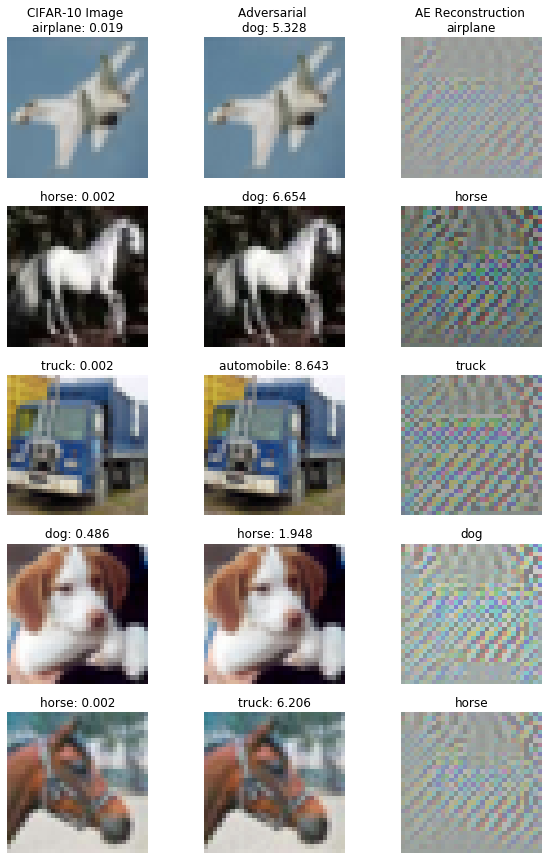

SLIDE attack...


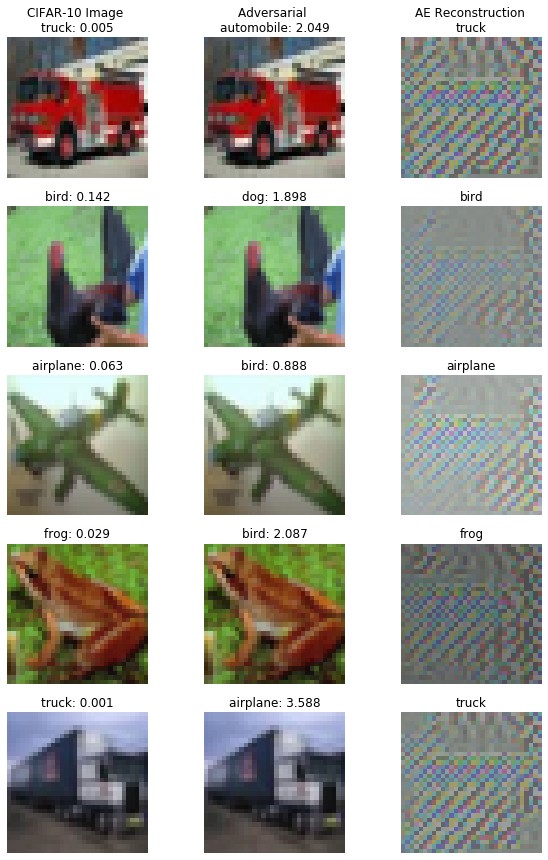

In [27]:
print('C&W attack...')
idx = [10, 13, 14, 16, 17]
plot_adversarial(idx, X_test, y_pred, X_test_cw, y_pred_cw, mean_test, std_test, 
                 score_x=score_x, score_x_adv=score_cw, X_recon=X_recon_cw, 
                 y_recon=y_recon_cw, figsize=(10, 15))
print('SLIDE attack...')
idx = [23, 25, 27, 29, 34]
plot_adversarial(idx, X_test, y_pred, X_test_slide, y_pred_slide, mean_test, std_test, 
                 score_x=score_x, score_x_adv=score_slide, X_recon=X_recon_slide, 
                 y_recon=y_recon_slide, figsize=(10, 15))

The ROC curves and AUC values show the effectiveness of the adversarial score to detect adversarial instances:

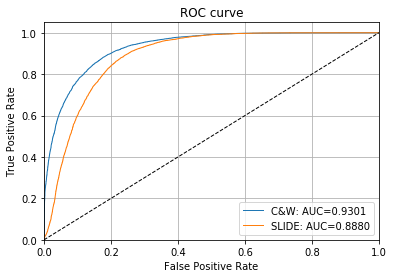

In [38]:
roc_data = {
    'original': {'scores': score_x, 'predictions': y_pred},
    'C&W': {'scores': score_cw, 'predictions': y_pred_cw, 'normal': 'original'},
    'SLIDE': {'scores': score_slide, 'predictions': y_pred_slide, 'normal': 'original'}
}

plot_roc(roc_data)

### Temperature Scaling

We can further improve the correction performance by applying temperature scaling on the original model predictions $M(x)$ during both training and inference when computing the adversarial scores. We can again load or train a detector from scratch:

$TODO$: training loop and fetching

In [29]:
detector_t_path = './models/ad_ae_cifar10/temperature/'
ad_t = load_detector(detector_t_path)

/home/avl/anaconda3/envs/detect/lib/python3.7/site-packages/tensorflow_core/python/keras/layers/core.py:986: UserWarning: official.vision.image_classification.resnet_cifar_model is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


In [30]:
# reconstructed adversarial instances
X_recon_cw_t = predict_batch(ad_t.ae, X_test_cw, batch_size=32, recon=True)
X_recon_slide_t = predict_batch(ad_t.ae, X_test_slide, batch_size=32, recon=True)

# make predictions on reconstructed instances and compute accuracy
y_recon_cw_t = predict_batch(clf, X_recon_cw_t, batch_size=32, recon=False)
y_recon_slide_t = predict_batch(clf, X_recon_slide_t, batch_size=32, recon=False)
acc_y_recon_cw_t = accuracy(y_test, y_recon_cw_t)
acc_y_recon_slide_t = accuracy(y_test, y_recon_slide_t)
print('Accuracy after C&W attack {:.4f} -- reconstruction {:.4f}'.format(acc_y_pred_cw, acc_y_recon_cw_t))
print('Accuracy after SLIDE attack {:.4f} -- reconstruction {:.4f}'.format(acc_y_pred_slide, 
                                                                           acc_y_recon_slide_t))

100%|██████████| 313/313 [00:23<00:00, 13.52it/s]

Accuracy after C&W attack 0.0000 -- reconstruction 0.8141
Accuracy after SLIDE attack 0.0002 -- reconstruction 0.8265


Applying temperature scaling to CIFAR-10 improves the ROC curve and AUC values.

In [31]:
score_x_t = score_batch(ad_t, X_test, batch_size=32)
score_cw_t = score_batch(ad_t, X_test_cw, batch_size=32)
score_slide_t = score_batch(ad_t, X_test_slide, batch_size=32)

100%|██████████| 313/313 [00:50<00:00,  6.23it/s]


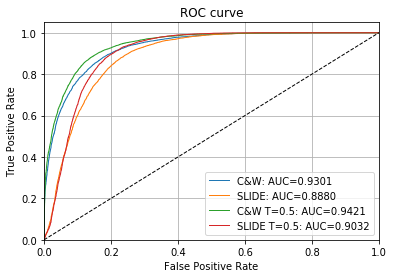

In [39]:
roc_data['original_t'] = {'scores': score_x_t, 'predictions': y_pred}
roc_data['C&W T=0.5'] = {'scores': score_cw_t, 'predictions': y_pred_cw, 'normal': 'original_t'}
roc_data['SLIDE T=0.5'] = {'scores': score_slide_t, 'predictions': y_pred_slide, 'normal': 'original_t'}

plot_roc(roc_data)

### Hidden Layer K-L Divergence

The performance of the correction mechanism can also be improved by extending the training methodology to one of the hidden layers of the classification model. We extract a flattened feature map from the hidden layer, feed it into a linear layer and apply the softmax function. The K-L divergence between predictions on the hidden layer for $x$ and $x'$ is optimised and included in the adversarial score during inference:

In [33]:
detector_hl_path = './models/ad_ae_cifar10/hiddenkld/'
ad_hl = load_detector(detector_hl_path)

In [34]:
# reconstructed adversarial instances
X_recon_cw_hl = predict_batch(ad_hl.ae, X_test_cw, batch_size=32, recon=True)
X_recon_slide_hl = predict_batch(ad_hl.ae, X_test_slide, batch_size=32, recon=True)

# make predictions on reconstructed instances and compute accuracy
y_recon_cw_hl = predict_batch(clf, X_recon_cw_hl, batch_size=32, recon=False)
y_recon_slide_hl = predict_batch(clf, X_recon_slide_hl, batch_size=32, recon=False)
acc_y_recon_cw_hl = accuracy(y_test, y_recon_cw_hl)
acc_y_recon_slide_hl = accuracy(y_test, y_recon_slide_hl)
print('Accuracy after C&W attack {:.4f} -- reconstruction {:.4f}'.format(acc_y_pred_cw, acc_y_recon_cw_hl))
print('Accuracy after SLIDE attack {:.4f} -- reconstruction {:.4f}'.format(acc_y_pred_slide, 
                                                                           acc_y_recon_slide_hl))

100%|██████████| 313/313 [00:24<00:00, 12.84it/s]

Accuracy after C&W attack 0.0000 -- reconstruction 0.8153
Accuracy after SLIDE attack 0.0002 -- reconstruction 0.8318


### Malicious Data Drift

The adversarial detector proves to be very flexible and can be used to measure the harmfulness of the data drift on the classifier. We evaluate the detector on the CIFAR-10-C dataset ([Hendrycks & Dietterich, 2019](https://arxiv.org/abs/1903.12261)). The instances in
CIFAR-10-C have been corrupted and perturbed by various types of noise, blur, brightness etc. at different levels of severity, leading to a gradual decline in model performance.

We can select from the following corruption types:

In [42]:
corruptions = corruption_types_cifar10c()
print(corruptions)

['brightness', 'contrast', 'defocus_blur', 'elastic_transform', 'fog', 'frost', 'gaussian_blur', 'gaussian_noise', 'glass_blur', 'impulse_noise', 'jpeg_compression', 'motion_blur', 'pixelate', 'saturate', 'shot_noise', 'snow', 'spatter', 'speckle_noise', 'zoom_blur']


Fetch the CIFAR-10-C data for a list of corruptions at a specified severity level (from 1 to 5):

In [44]:
X_corr, y_corr = fetch_cifar10c(corruption=corruptions, severity=1, return_X_y=True)
print(X_corr.shape, y_corr.shape)

In [ ]:
severities = [1,2,3,4,5]
corruption = 'all'
model_path = '../models/ae/cifar10/v1/9_s0/20'
dataset = 'cifar10'

# load model and dataset
ad, clf = load_detector(dataset, model_path, is_weak=False)
orig = load_dataset(dataset, 'cw', preprocess=True, include_adversarial=True)[0]
(X_train, y_train), (X_test, y_test) = orig

print('Make predictions on original dataset...')
orig_preds = predict_batch(clf, X_test, batch_size=256, recon=False)
acc_orig = accuracy(y_test, orig_preds)

print('Compute scores on original dataset...')
score_orig_test = score_batch(ad, X_test)

scores_s = []
labels_s = []
scores_dict = {
    1: {'all': [], 'harm': [], 'noharm': [], 'acc': 0},
    2: {'all': [], 'harm': [], 'noharm': [], 'acc': 0},
    3: {'all': [], 'harm': [], 'noharm': [], 'acc': 0},
    4: {'all': [], 'harm': [], 'noharm': [], 'acc': 0},
    5: {'all': [], 'harm': [], 'noharm': [], 'acc': 0},
}

for s in severities:
    print('\nSeverity: {}'.format(s))
    
    print('Loading corrupted dataset...')
    (X_corr, y_corr), scale_corr = load_cifar10c(corruption, s, preprocess=True)
    
    print('Make predictions on corrupted dataset...')
    corr_preds = predict_batch(clf, X_corr, batch_size=256, recon=False)
    
    print('Compute scores on corrupted dataset...')
    score_corr_test = score_batch(ad, X_corr)
    scores = np.concatenate([score_orig_test, score_corr_test])
    
    print('Get labels...')
    labels_corr = np.zeros(score_corr_test.shape[0])    
    repeat = y_corr.shape[0] // y_test.shape[0]
    orig_preds_repeat = np.tile(orig_preds, (repeat,))
    idx_orig_right = np.where(orig_preds_repeat == y_corr)[0]
    idx_corr_wrong = np.where(corr_preds != y_corr)[0]
    idx = np.intersect1d(idx_orig_right, idx_corr_wrong)
    labels_corr[idx] = 1
    labels = np.concatenate([np.zeros(X_test.shape[0]), labels_corr]).astype(int)
    
    idx_corr_right = np.where(corr_preds == y_corr)[0]
    idx_right = np.intersect1d(idx_orig_right, idx_corr_right)
    
    scores_dict[s]['all'] = score_corr_test
    scores_dict[s]['harm'] = score_corr_test[idx]
    scores_dict[s]['noharm'] = score_corr_test[idx_right]
    scores_dict[s]['acc'] = accuracy(y_corr, corr_preds)
    
    scores_s.append(scores)
    labels_s.append(labels)

In [ ]:
mu_noharm = []
std_noharm = []
mu_harm = []
std_harm = []
acc = [acc_orig]
for k, v in scores_dict.items():
    mu_noharm.append(v['noharm'].mean())
    std_noharm.append(v['noharm'].std())
    mu_harm.append(v['harm'].mean())
    std_harm.append(v['harm'].std())
    acc.append(v['acc'])

In [ ]:
plot_labels = ['0', '1', '2', '3', '4', '5']

N = 6
ind = np.arange(N)
width = .35

fig_bar_cd, ax = plt.subplots()
ax2 = ax.twinx()

p0 = ax.bar(ind[0], score_orig_test.mean(), yerr=score_orig_test.std(), capsize=2)
p1 = ax.bar(ind[1:], mu_noharm, width, yerr=std_noharm, capsize=2)
p2 = ax.bar(ind[1:] + width, mu_harm, width, yerr=std_harm, capsize=2)

ax.set_title('Adversarial Scores and Accuracy by Corruption Severity')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(plot_labels)
ax.set_ylim((-1,6))
ax.legend((p1[0], p2[0]), ('Not Harmful', 'Harmful'), loc='upper right', ncol=2)
#plt.legend(loc="lower right", ncol=2, bbox_to_anchor=(0.5, 0., 0.5, 0.5))
ax.set_ylabel('Score')
ax.set_xlabel('Corruption Severity')

color = 'tab:red'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(acc, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.show()

In [ ]:
ks_stats = {}
for k, v in scores_dict.items():
    d, p_val = ks_2samp(v['noharm'], v['harm'])
    ks_stats[k] = {}
    ks_stats[k]['d'] = d
    ks_stats[k]['p_val'] = p_val
print(ks_stats)

### Test

In [20]:
import pickle
detector_path = './models/ad_ae_cifar10/mse_alt/'
detector_name = 'AdversarialAE'
ad_meta = {'detector_type': 'offline', 'data_type': 'image', 'name': 'AdversarialAE'}
state_dict = {'threshold': None, 'w_model_hl': None, 'temperature': 1.,
              'hidden_layer_kld': None}  # {200: 20}
with open(os.path.join(detector_path, 'meta.pickle'), 'wb') as f:
    pickle.dump(ad_meta, f)
with open(os.path.join(detector_path, detector_name + '.pickle'), 'wb') as f:
    pickle.dump(state_dict, f)

To highlight the importance of the custom autoencoder loss, we can compare it with the performance of a detector trained with the mean squared error (MSE) loss. We can fetch the detector, reconstruct the adversarial instances, show the ROC curve and compute the AUC:

In [ ]:
detector_mse_path = './models/ad_ae_cifar10/mse_alt/'
ad_mse = load_detector(detector_mse_path)

# reconstructed adversarial instances
X_recon_cw_mse = predict_batch(ad_mse.ae, X_test_cw, batch_size=32, recon=True)
X_recon_slide_mse = predict_batch(ad_mse.ae, X_test_slide, batch_size=32, recon=True)
# X_recon_mse = predict_batch(ad_mse.ae, X_test, batch_size=32, recon=True)

# make predictions on reconstructed instances and compute accuracy
y_recon_cw_mse = predict_batch(clf, X_recon_cw_mse, batch_size=32, recon=False)
y_recon_slide_mse = predict_batch(clf, X_recon_slide_mse, batch_size=32, recon=False)
acc_y_recon_cw_mse = accuracy(y_test, y_recon_cw_mse)
acc_y_recon_slide_mse = accuracy(y_test, y_recon_slide_mse)
print('Accuracy after C&W attack {:.4f} -- reconstruction {:.4f}'.format(acc_y_pred_cw, acc_y_recon_cw_mse))
print('Accuracy after SLIDE attack {:.4f} -- reconstruction {:.4f}'.format(acc_y_pred_slide, 
                                                                           acc_y_recon_slide_mse))

### Correct

In [47]:
xrecon = predict_batch(ad_t.ae, X_test_cw, batch_size=32, recon=True)
print(xrecon.shape)

100%|██████████| 313/313 [00:05<00:00, 62.06it/s]

(10000, 32, 32, 3)


In [49]:
yrecon = predict_batch(clf, xrecon, batch_size=32, recon=False)

100%|██████████| 313/313 [00:18<00:00, 17.09it/s]


In [50]:
accuracy(yrecon, y_test)

0.8141

In [51]:
adv_score = score_batch(ad_t, X_test_cw, batch_size=32)

100%|██████████| 313/313 [00:43<00:00,  7.26it/s]


In [58]:
threshold = 0.2

In [59]:
adv_pred = (adv_score > threshold).astype(int)
adv_pred.sum()

9524

In [61]:
adv_pred[:50]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

In [62]:
ypreds = predict_batch(clf, X_test_cw, batch_size=32, recon=False)

100%|██████████| 313/313 [00:19<00:00, 15.95it/s]


In [63]:
ypreds.shape

(10000,)

In [64]:
ypreds[:10]

array([5, 1, 1, 8, 2, 3, 3, 3, 5, 9])

In [67]:
idx_adv = np.where(adv_pred == 1)[0]

In [68]:
idx_adv

array([   0,    1,    2, ..., 9997, 9998, 9999])